In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Cargar el CSV que acabamos de generar
df = pd.read_csv("../data/processed/segmento1_csv/segmento1_2025_indicadores.csv")

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 45 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      57 non-null     object
 1   Unnamed: 1      44 non-null     object
 2   Unnamed: 2      42 non-null     object
 3   Menú Principal  42 non-null     object
 4   Unnamed: 4      42 non-null     object
 5   Unnamed: 5      42 non-null     object
 6   Unnamed: 6      42 non-null     object
 7   Unnamed: 7      42 non-null     object
 8   Unnamed: 8      42 non-null     object
 9   Unnamed: 9      42 non-null     object
 10  Unnamed: 10     42 non-null     object
 11  Unnamed: 11     42 non-null     object
 12  Unnamed: 12     42 non-null     object
 13  Unnamed: 13     42 non-null     object
 14  Unnamed: 14     42 non-null     object
 15  Unnamed: 15     42 non-null     object
 16  Unnamed: 16     42 non-null     object
 17  Unnamed: 17     42 non-null     object
 18  Unnamed: 18 

In [24]:
import pandas as pd

# 1) Leer el CSV SIN encabezado
ruta_csv = "../data/processed/segmento1_csv/segmento1_2025_indicadores.csv"  # ajusta si es necesario
raw = pd.read_csv(ruta_csv, header=None, dtype=str)

print("Shape original:", raw.shape)

# 2) Eliminar filas y columnas totalmente vacías
raw = raw.dropna(how="all").reset_index(drop=True)
raw = raw.dropna(axis=1, how="all")
print("Shape después de eliminar filas/columnas vacías:", raw.shape)

# 3) Buscar la fila que contiene 'VT_TOTAL SEGMENTO 1' (fila con nombres de cooperativas)
mask_header = raw.apply(
    lambda fila: fila.astype(str).str.contains("VT_TOTAL SEGMENTO 1", na=False).any(),
    axis=1,
)

rows_header = mask_header[mask_header].index

if len(rows_header) == 0:
    raise ValueError("No encontré la fila que contiene 'VT_TOTAL SEGMENTO 1'")

header_idx = rows_header[0]
print("Fila de encabezado real:", header_idx)

# 4) Definir encabezados y dataframe de datos
header = raw.iloc[header_idx].fillna("").tolist()
df = raw.iloc[header_idx + 1 :].reset_index(drop=True)
df.columns = header

# 5) Renombrar la primera columna (que tiene los nombres de indicadores)
primera_col = df.columns[0]
df = df.rename(columns={primera_col: "Indicador"})

# Quitar filas vacías de indicadores
df = df[df["Indicador"].notna() & (df["Indicador"].str.strip() != "")]

print("Columnas finales:", len(df.columns))
print(df.head())
df.info()


Shape original: (69, 45)
Shape después de eliminar filas/columnas vacías: (60, 45)
Fila de encabezado real: 7
Columnas finales: 45
                                           Indicador    15 DE ABRIL LTDA  \
0                            SUFICIENCIA PATRIMONIAL                 NaN   
1  ( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILI...  1.3205419032612622   
2                    ESTRUCTURA Y CALIDAD DE ACTIVOS                 NaN   
3        ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS  0.1231019620629989   
4                ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS  0.8768980379370008   

  23 DE JULIO LIMITADA   29 DE OCTUBRE LTDA    9 DE OCTUBRE LTDA  \
0                  NaN                  NaN                  NaN   
1     2.07645668431951   2.1835470705009654   2.7883896620405295   
2                  NaN                  NaN                  NaN   
3   0.0917480079425534  0.07341648004327188  0.07890132214356334   
4   0.9082519920574467   0.9265835199567282   0.9210986778564365   

  A

In [35]:
# 1) Eliminar columnas tipo "Unnamed"
df_clean = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# 2) Eliminar filas completamente vacías
df_clean = df_clean.dropna(how="all").reset_index(drop=True)

df_clean.head()
df_clean.info()
df_clean.columns.tolist()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 45 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Indicador                                                         52 non-null     object 
 1   15 DE ABRIL LTDA                                                  41 non-null     float64
 2   23 DE JULIO LIMITADA                                              41 non-null     float64
 3   29 DE OCTUBRE LTDA                                                41 non-null     float64
 4   9 DE OCTUBRE LTDA                                                 41 non-null     float64
 5   ALFONSO JARAMILLO LEON CAJA                                       41 non-null     float64
 6   ALIANZA DEL VALLE LIMITADA                                        41 non-null     float64
 7   AMBATO LTDA                          

['Indicador',
 '15 DE ABRIL LTDA',
 '23 DE JULIO LIMITADA',
 '29 DE OCTUBRE LTDA',
 '9 DE OCTUBRE LTDA',
 'ALFONSO JARAMILLO LEON CAJA',
 'ALIANZA DEL VALLE LIMITADA',
 'AMBATO LTDA',
 'ANDALUCIA LIMITADA',
 'ATUNTAQUI LIMITADA',
 'CALCETA LTDA',
 'CHIBULEO LIMITADA',
 'CHONE LTDA',
 'COMERCIO LTDA',
 'COOPROGRESO LIMITADA',
 'DE LA PEQUEÑA EMPRESA BIBLIAN LIMITADA',
 'DE LA PEQUEÑA EMPRESA CACPE LOJA LTDA',
 'DE LA PEQUEÑA EMPRESA DE COTOPAXI LIMITADA',
 'DE LA PEQUEÑA EMPRESA DE PASTAZA LIMITADA',
 'DE LA PEQUEÑA EMPRESA GUALAQUIZA',
 'DE LOS SERVIDORES PUBLICOS DEL MINISTERIO DE EDUCACION Y CULTURA',
 'EL SAGRARIO LTDA',
 'ERCO LIMITADA',
 'FERNANDO DAQUILEMA LIMITADA',
 'INDIGENA SAC LTDA',
 'JARDIN AZUAYO LIMITADA',
 'JUVENTUD ECUATORIANA PROGRESISTA LIMITADA',
 'KULLKI WASI LTDA',
 'LA MERCED LIMITADA',
 'LUCHA CAMPESINA',
 'MUSHUC RUNA LTDA',
 'ONCE DE JUNIO LTDA',
 'OSCUS LIMITADA',
 'PABLO MUÑOZ VEGA LIMITADA',
 'PADRE JULIAN LORENTE LTDA',
 'PILAHUIN TIO LIMITADA',
 'POLICIA 

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# df_real = tu dataframe final limpio
df = df_real.copy()

# ============================
# 1) Dejar "Indicador" como índice (filas = indicadores)
# ============================
df = df.set_index("Indicador")

# ============================
# 2) Transponer → filas = cooperativas / columnas = indicadores
# ============================
df_T = df.T

# ============================
# 3) Escalar los datos
# ============================
scaler = StandardScaler()
X = scaler.fit_transform(df_T)

# ============================
# 4) PCA con 2 componentes
# ============================
pca = PCA(n_components=2)
pc = pca.fit_transform(X)

df_pca = pd.DataFrame(pc, columns=["PC1", "PC2"])
df_pca["Cooperativa"] = df_T.index  # ahora sí coincide el tamaño

df_pca.head()


,PC1,PC2,Cooperativa
0,-2.922523,1.428373,15 DE ABRIL LTDA
1,-2.099070,0.624598,23 DE JULIO LIMITADA
2,-1.525842,-0.911797,29 DE OCTUBRE LTDA
3,-0.246313,0.613767,9 DE OCTUBRE LTDA
4,-0.587621,0.651456,ALFONSO JARAMILLO LEON CAJA


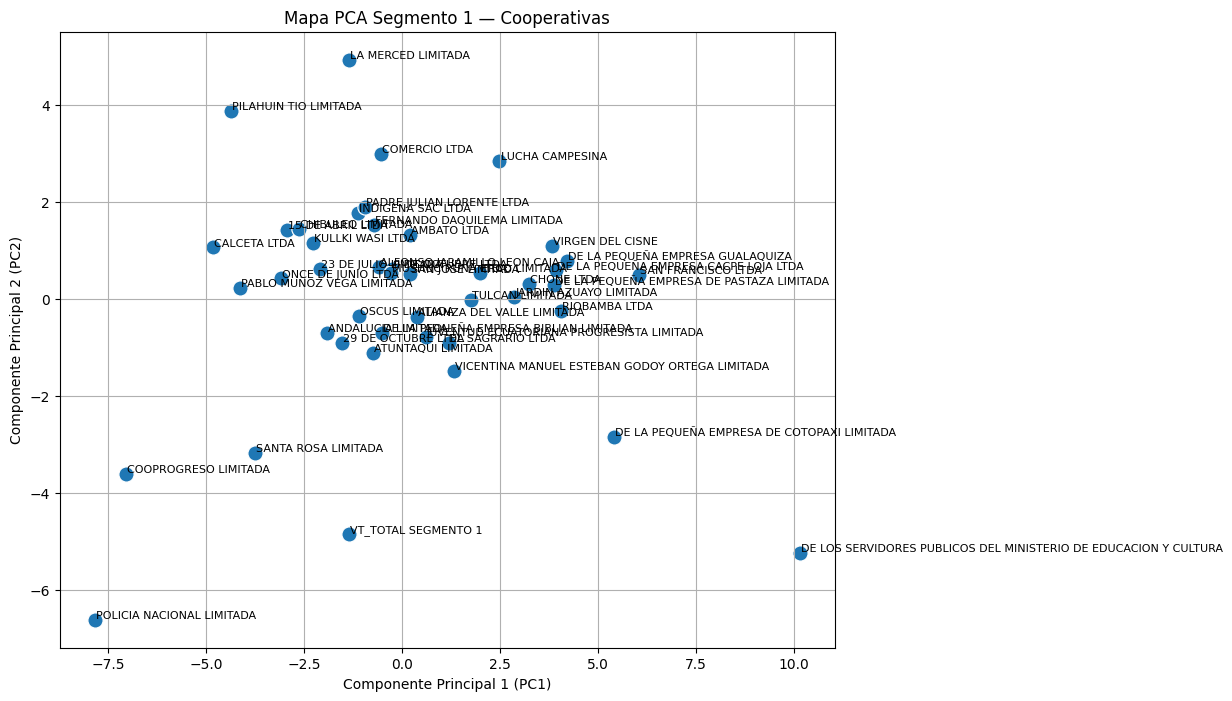

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))

sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    s=120,
    color="#1f77b4"
)

# Etiquetas de cooperativas en el gráfico
for i in range(len(df_pca)):
    plt.text(
        df_pca.PC1[i] + 0.03,
        df_pca.PC2[i] + 0.03,
        df_pca.Cooperativa[i],
        fontsize=8
    )

plt.title("Mapa PCA Segmento 1 — Cooperativas")
plt.xlabel("Componente Principal 1 (PC1)")
plt.ylabel("Componente Principal 2 (PC2)")
plt.grid(True)
plt.show()


In [50]:
df_ranking = df_pca.sort_values(by="PC1", ascending=False).reset_index(drop=True)
df_ranking.head(10)


,PC1,PC2,Cooperativa,Score
0,10.147276,-5.251062,DE LOS SERVIDORES PUBLICOS DEL MINISTERIO DE E...,4.896214
1,6.046562,0.488972,SAN FRANCISCO LTDA,6.535534
2,5.418352,-2.849933,DE LA PEQUEÑA EMPRESA DE COTOPAXI LIMITADA,2.568419
3,4.216566,0.775668,DE LA PEQUEÑA EMPRESA GUALAQUIZA,4.992234
4,4.069220,-0.251058,RIOBAMBA LTDA,3.818162
5,3.938175,0.588750,DE LA PEQUEÑA EMPRESA CACPE LOJA LTDA,4.526925
6,3.871982,0.278443,DE LA PEQUEÑA EMPRESA DE PASTAZA LIMITADA,4.150425
7,3.830453,1.100220,VIRGEN DEL CISNE,4.930673
8,3.237702,0.311665,CHONE LTDA,3.549367
9,2.869928,0.040114,JARDIN AZUAYO LIMITADA,2.910043


In [51]:
import numpy as np

df_pca["z_pc1"] = (df_pca["PC1"] - df_pca["PC1"].mean()) / df_pca["PC1"].std()
df_pca["z_pc2"] = (df_pca["PC2"] - df_pca["PC2"].mean()) / df_pca["PC2"].std()

outliers = df_pca[(df_pca["z_pc1"].abs() > 2.5) | (df_pca["z_pc2"].abs() > 2.5)]
outliers


,PC1,PC2,Cooperativa,Score,z_pc1,z_pc2
19,10.147276,-5.251062,DE LOS SERVIDORES PUBLICOS DEL MINISTERIO DE E...,4.896214,2.924381,-2.364386
35,-7.828026,-6.621888,POLICIA NACIONAL LIMITADA,-14.449914,-2.255988,-2.981625


In [59]:
from sklearn.preprocessing import StandardScaler

X_cluster = df_real.iloc[:, 1:]   # solo números
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


In [58]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_clusters = pd.DataFrame({
    "Cooperativa": df_clean.columns[1:], 
    "Cluster": clusters
})

df_clusters.head()


ValueError: All arrays must be of the same length